# Kubernetes cluster configuration

*As a dev, I want to focus on my business application.*

First, you need to bootstrap some dependencies such as `kubectl`, `helm`.

[Here](bootstrap.ipynb) are some quick commands to help you.

### Check your cluster config

Fetch your kube config file from the OVH Manager and save it in your local folder.

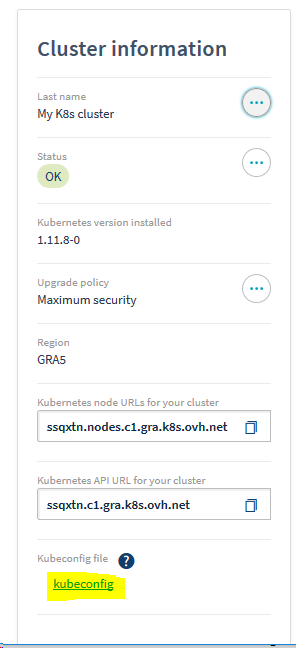

or via the OVH API https://api.ovh.com/console/#/kube/%7BserviceName%7D/kubeconfig#GET

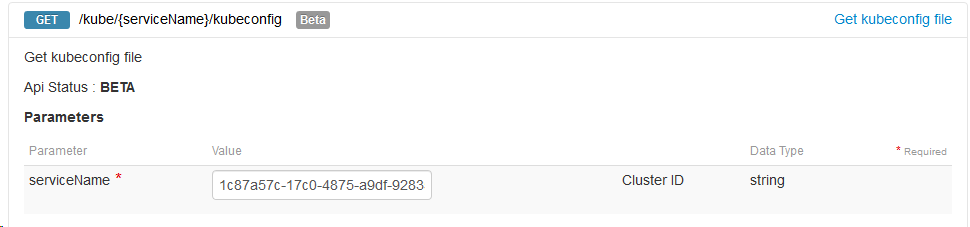

**Note**: If you are using the API UI, you need to copy/paste the response in `kubeconfig.yaml` and run `sed -i 's/\\n/\n/g' kubeconfig.yaml`

Next, set the `KUBECONFIG` environment variable.


In [ ]:
export KUBECONFIG=`pwd`/kubeconfig.yaml

and check that you can access your cluster. Be sure to install [kubectl](bootstrap.ipynb#Install-kubctl) first.

In [ ]:
export PATH=`pwd`:$PATH
kubectl cluster-info

Check that you can connect and start adding your node, either via the OVH manager

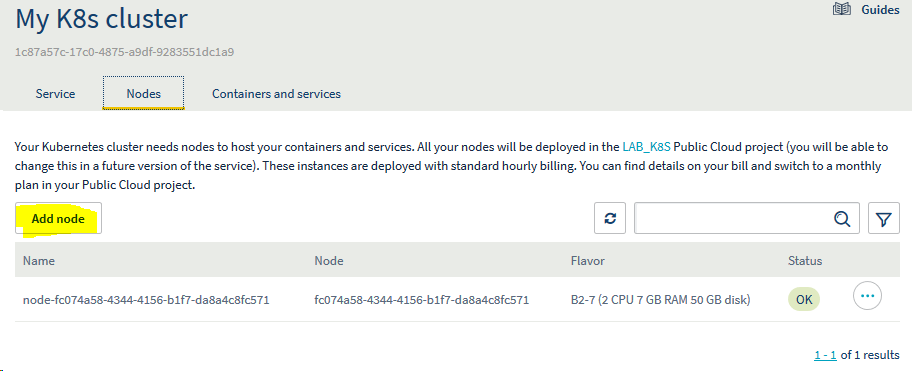

or the OVH API https://api.ovh.com/console/#/kube/%7BserviceName%7D/publiccloud/node#GET

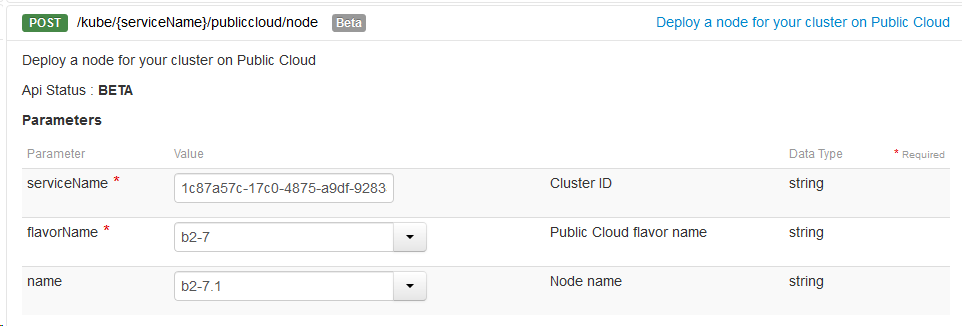

In [ ]:
kubectl get nodes

## Helm/Tiller

Next, to simplify our deployement, we'll use helm.

[Helm](https://github.com/helm/helm) is a tool for managing packages of pre-configured Kubernetes resources known as _charts_.

It has two componenents:

- a local client `helm` to [install](https://helm.sh/docs/using_helm/#install-helm) in your local environment.
- a Kubernetes service `tiller`.

### Configure RBAC for Tiller

To allow tiller to manager the chars, we need first to create a `ServiceAccount` and give it `cluster-admin` rights.

The full doc is available [here](https://docs.gitlab.com/ee/install/kubernetes/preparation/tiller.html)


In [ ]:
cat > config.yml <<EOF
apiVersion: v1
kind: ServiceAccount
metadata:
  name: tiller
  namespace: kube-system
---
apiVersion: rbac.authorization.k8s.io/v1
kind: ClusterRoleBinding
metadata:
  name: tiller
roleRef:
  apiGroup: rbac.authorization.k8s.io
  kind: ClusterRole
  name: cluster-admin
subjects:
  - kind: ServiceAccount
    name: tiller
    namespace: kube-system
EOF

In [ ]:
kubectl apply -f config.yml # apply config

### Init helm

Use the `--upgrade` if `tiller`is already installed. Be sure to install [helm](bootstrap.ipynb#Install-helm) first.


In [ ]:
export PATH=`pwd`:$PATH
helm init --upgrade --service-account tiller # deploy the service in the remote cluster

In [ ]:
kubectl get pods -n kube-system -l app=helm # check that the pod is up and running

In [ ]:
helm version # check that both client and server version are the same

In [ ]:
helm repo update # Update the helm package list

# Install the IngressController

First thing first, we'll deploy a `LoadBalancer` and NGINX `IngressController` with `helm`.

You'll be using this [chart](https://github.com/helm/charts/tree/master/stable/nginx-ingress) and deploy it in the `kube-public` namespace.

In [ ]:
helm install stable/nginx-ingress --namespace kube-public --set controller.replicaCount=2

# Install MongoDB

The chart documetation is available [here](https://github.com/helm/charts/tree/master/stable/mongodb)

First, we will delete any existing MongoDB deployement and then deploy a new one.

In [ ]:
helm del --purge my-mongodb

In [ ]:
helm install --name my-mongodb stable/mongodb

Check that the pod is up and running

In [ ]:
kubectl get pods,service --namespace=default -l release=my-mongodb -o wide

# Install ElasticSearch

The chart documetation is available [here](https://github.com/elastic/helm-charts/tree/master/elasticsearch)

ElasticSearch will require to have at least 3 nodes available.

First, we need to install ElasticSearch helm repository

In [ ]:
helm repo add elastic https://helm.elastic.co

In [ ]:
helm del --purge my-elasticsearch # delete if already installed

In [ ]:
helm install --name my-elasticsearch elastic/elasticsearch --set volumeClaimTemplate.storageClassName=cinder-high-speed

**Note**: The list of `storageClassName` is available via `kubectl get sc`.

Check that the pods are up and running

In [ ]:
kubectl get pods,service --namespace=default -l app=elasticsearch-master -o wide

From this step, you should have working ElasticSearch and MongoDB services.

Let's move to Gravitee.io.

# Install Gravitee.io

[gravitee.io](https://gravitee.io/) is an api manager. It could be seen as an [`IngressController`](https://kubernetes.io/docs/concepts/services-networking/ingress/)but with a developper point of view.

The setup is described [here](gravitee-setup.ipynb)

# Install Linkerd

The following commands are detailed [here](https://linkerd.io/2/getting-started/)


In [ ]:
linkerd check --pre && (linkerd install | kubectl apply -f -) # do a pre-check and install

In [ ]:
linkerd check # check installation went fine

You can open a tunnel to access Linkerd dashboard. Run the following command in a separate termminal
```
linkerd dashboard
```

Once linkerd is installed and configured, only an extra step is needed for the `Ingress`. In our case with NGINX, we have to follow this [documentation](https://linkerd.io/2/tasks/using-ingress/)

In [ ]:
kubectl annotate ing gravitee-ui 'nginx.ingress.kubernetes.io/upstream-vhost=$service_name.$namespace.svc.cluster.local'
kubectl annotate ing gravitee-api 'nginx.ingress.kubernetes.io/upstream-vhost=$service_name.$namespace.svc.cluster.local'
kubectl annotate ing gravitee-gateway 'nginx.ingress.kubernetes.io/upstream-vhost=$service_name.$namespace.svc.cluster.local'